# Nuclei Detection using CNNs and U-net Architecture with Data Augmentation

+ I will be trying two to three architectures and finally report the LB scores 
+ I will put down the benifits and disadvantages of each approach
+ I will add Data augmentation here also for this trial


## Steps From Start to Finish 
1. Imports and Tools to Use for this project
2. Import the Data using Awazon s3 buckets and Amazon Sagemaker Jupyter Instance
3. Analyze the Data
4. Understanding the IOU metric and writing its custom definition for the mean IOU function
5. Defining the Architecture/model to be used
6. Training the Network 
7. Make predictions on the Training , Validation and the test sets
8. RLE Encoding and Submitting the results

**Steps 5 to 8 will be repeated with every new Model that I will try for this project**

### How did I access the AWS s3 Buckets using Sagemaker ?

- Using the sagemaker tutorials @ https://us-west-2.console.aws.amazon.com/sagemaker/home?region=us-west-2#/notebook-instances/Nucleidetection-Trial-1
- You transform the data by changing its format from numpy.array to RecordIO. The RecordIO format is more efficient for the algorithms provided by Amazon SageMaker. For information about the RecordIO format, see http://mxnet.incubator.apache.org/architecture/note_data_loading.html#data-format
+ Accesing s3 buckets using **boto3** package https://dluo.me/s3databoto3
+ SO information : https://stackoverflow.com/questions/35803027/retrieving-subfolders-names-in-s3-bucket-from-boto3

## 1. Imports and Tools to Use for this project

In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import skimage.transform
import skimage.morphology

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

#For some visualiations
import sklearn.model_selection 
import keras.preprocessing.image # For image generation and augmentation
import datetime
import cv2
import seaborn as sns
import matplotlib.cm as cm # color map

#For Sagemaker and s3 bucket linking and access
from sagemaker import get_execution_role
import boto3

import tensorflow as tf
%matplotlib inline

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '
Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## 2. Import the Data using Awazon s3 buckets and Amazon Sagemaker Jupyter Instance
+ Created the s3 Bucket and uploaded the data in the bucket named = 'sagemaker-datascience-bowl'
+ Used the boto3 package the access the path and the bucket contents
+ Do Not fix the seed here, will give problems later while using Data augmentation, hence that portion is commented

In [2]:
# Set some parameters
# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
#TRAIN_PATH = '../input/stage1_train/'
#TEST_PATH = '../input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
#seed = 42
#random.seed = seed
#np.random.seed = seed

In [3]:

role=get_execution_role()
bucket='sagemaker-datascience-bowl'

In [4]:
%%time
import pickle, gzip, numpy, urllib.request, json

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 14.1 µs


In [5]:
%%time

client=boto3.client('s3')

response=client.list_buckets()
buckets=[bucket['Name'] for bucket in response['Buckets']]
print("Bucket List: %s"% buckets)

data_key='stage1_train/'
data_location='s3://{}//{}'.format(bucket, data_key)

Bucket List: ['sagemaker-datascience-bowl']
CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 560 ms


In [6]:
folders=[]
paginator = client.get_paginator('list_objects')
for result in paginator.paginate(Bucket=bucket, Delimiter='/'):
    for prefix in result.get('CommonPrefixes'):
        folders.append(prefix.get('Prefix'))
print(folders)        

['stage1_sample_submission.csv/', 'stage1_test/', 'stage1_train/', 'stage1_train_labels.csv/']


In [7]:
paths = [ bucket+"/"+p for p in folders]
paths

['sagemaker-datascience-bowl/stage1_sample_submission.csv/',
 'sagemaker-datascience-bowl/stage1_test/',
 'sagemaker-datascience-bowl/stage1_train/',
 'sagemaker-datascience-bowl/stage1_train_labels.csv/']

In [8]:
resource = boto3.resource('s3')
my_bucket = resource.Bucket(bucket)
files_train=list(my_bucket.objects.filter(Prefix=folders[2]))
files_test=list(my_bucket.objects.filter(Prefix=folders[1]))

## 3. Analyze the Data 

### Get the Train and the Test Ids here
+ Train Ids and Test Ids Extraction 
+ Checking some random Training imgages 
+ Checking some random Test images
+ Checking the Shapes of the images 

In [9]:
print("--------------------------------------Training image files in s3 bucket information----------------------")
print("\n\n")
# Check the paths for images and texts in the train folder randomly
for i in range(28):
    print(files_train[i].key.split("/")[2],"  ",files_train[i].key.split("/")[3])
print("---------------------------------------------------------------------------")
print(files_train[28].key.split("/")[2]," ",files_train[28].key.split("/")[3])
print("\n\n")
print("--------------------------------------Test images files in s3 bucket information------------------------")
# check the paths for images in the test folder, test folder does not have any masks
for i in range(10):
    print(files_test[i].key.split("/")[2]," ",files_test[i].key.split("/")[3])
print("\n\n")    
print("Length of the the test folder:{}".format(len(files_test)))    

--------------------------------------Training image files in s3 bucket information----------------------



images    00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552.png
masks    07a9bf1d7594af2763c86e93f05d22c4d5181353c6d3ab30a345b908ffe5aadc.png
masks    0e548d0af63ab451616f082eb56bde13eb71f73dfda92a03fbe88ad42ebb4881.png
masks    0ea1f9e30124e4aef1407af239ff42fd6f5753c09b4c5cac5d08023c328d7f05.png
masks    0f5a3252d05ecdf453bdd5e6ad5322c454d8ec2d13ef0f0bf45a6f6db45b5639.png
masks    2c47735510ef91a11fde42b317829cee5fc04d05a797b90008803d7151951d58.png
masks    4afa39f2a05f9884a5ff030d678c6142379f99a5baaf4f1ba7835a639cb50751.png
masks    4bc58dbdefb2777392361d8b2d686b1cc14ca310e009b79763af46e853e6c6ac.png
masks    4e3b49fb14877b63704881a923365b68c1def111c58f23c66daa49fef4b632bf.png
masks    5522143fa8723b66b1e0b25331047e6ae6eeec664f7c8abeba687e0de0f9060a.png
masks    58656859fb9c13741eda9bc753c3415b78d1135ee852a194944dee88ab70acf4.png
masks    6442251746caac8fc255e6a

In [10]:
train_ids = [files_train[i].key.split('/')[1].strip() for i in range(len(files_train)) if 'images' in files_train[i].key.split('/')]
test_ids = [files_test[i].key.split('/')[1].strip() for i in range(len(files_test))]
print(len(train_ids), len(test_ids))
print(train_ids[0:10])
print("\n")
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks')
sys.stdout.flush()

from io import BytesIO
count=0
for n, id_ in tqdm(enumerate(files_train)):
    tag = files_train[n].key.split('/')[1]   #to tag masks or images , this is not required
    id_train = files_train[n].key.split('/') #splitted key
    if 'images' in id_train: 
        #print("shape of the train image {}".format(path_im_train[1]),imread(files_train[i].get()['Body']).shape)
        img=imread(files_train[n].get()['Body'])[:,:,:IMG_CHANNELS]
        img=resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[count]=img
        count+=1
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    elif 'masks' in id_train:
        mask_ = imread(files_train[n].get()['Body'])
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        Y_train[count-1]=mask
print(count)        
#     print("------------------------------Test------------------------")
#     print("shape of the test image {}".format(path_im_test[1]),imread(files_test[i].get()['Body']).shape)
#     img_ts = imread(files_test[i].get()['Body'])[:,:,:IMG_CHANNELS]
#     img_ts = resize(img_ts, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
#     imshow(img_ts)
#     plt.show()
#     imread(files_test[i].get()['Body']).shape

670 65
['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552', '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1', '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e', '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed', '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf', '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21', '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426', '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339', '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776', '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe']


Getting and resizing train images and masks


30131it [26:57, 18.63it/s]

670


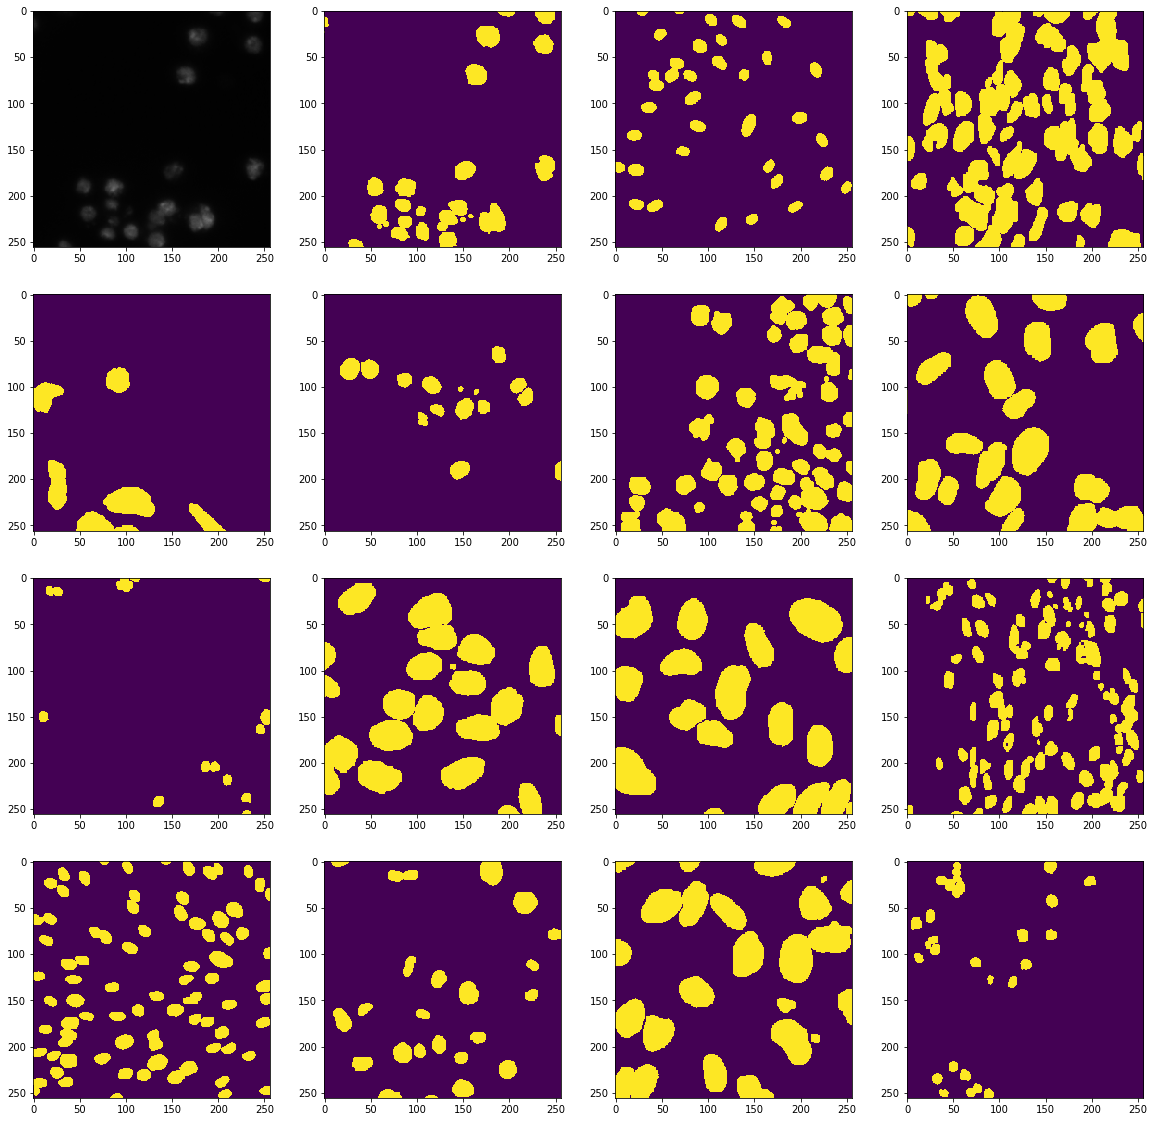

In [11]:
## Overview of train images and masks

fig, axes = plt.subplots(4,4, figsize=(20,20))
axes[0,0].imshow(X_train[0])
axes[0,1].imshow(np.squeeze(Y_train[0]))
axes[0,2].imshow(np.squeeze(Y_train[1]))
axes[0,3].imshow(np.squeeze(Y_train[2]))
count=3
for i in range(1,4):
    for j in range(4):
        count+=1
        axes[i,j].imshow(np.squeeze(Y_train[count]))

In [12]:
# Get and resize test images as well and take a look

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test=[]
print('Getting and resizing the test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(files_test), total=len(files_test)):
    img = imread(files_test[n].get()['Body'])[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img=resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n]=img
print('Done the processing !!')    

Getting and resizing the test images ... 


100%|██████████| 65/65 [00:07<00:00,  8.64it/s]

Done the processing !!


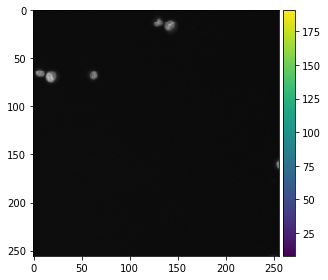

In [13]:
ix=random.randint(0, len(test_ids))
imshow(X_test[ix])
plt.show()

## 4. Understanding the IOU metric to calculate the mean average Precision metric 
+ We use Keras for defining this metric , this metric is also defined in TF
+ Iou is Intersection over Union , as the name suggests, This metric support is not predefined and we need to define this on our own 
+ As I go through in implementing this function, I find that it is not easy to implement the tf.metrics.mean_iou(), All that is given in the tensorflow docs, is below, Basically this just tells us what IoU is, but does not tell in detail how to use it
+ **Calculate per-step mean Intersection-Over-Union (mIOU).**

    + Mean Intersection-Over-Union is a common evaluation metric for semantic image segmentation, which first computes the IOU for each semantic class and then computes the average over classes. IOU is defined as follows: IOU = true_positive / (true_positive + false_positive + false_negative). The predictions are accumulated in a confusion matrix, weighted by weights, and mIOU is then calculated from it.

    + For estimation of the metric over a stream of data, the function creates an update_op operation that updates these variables and returns the mean_iou.
    
+ **As per the competition , the definition of the function is as below**
    + This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:
    > **IoU(A,B)=A∩B/A∪B.** 
    
    **The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.**

    + At each threshold value t, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:
    > **TP(t)/(TP(t)+FP(t)+FN(t))**
    

+ A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold:Lastly, the score returned by the competition metric is the mean taken over the individual average precisions of each image in the test dataset.

+ There is some reading involved here , and there are some implementations that I have to go through, putting down my resources that have inspired me and helped me design this metric
    - https://www.kaggle.com/c/data-science-bowl-2018/discussion/47690
    - https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277
    - http://ronny.rest/blog/post_2017_09_11_tf_metrics/

In [14]:
# define the IOU function using tf.metrics.mean_iou, this is a much simpler implementation and straight to use

def mean_iou(y_true, y_pred):
    prec=[]
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_=tf.to_int32(y_pred>t)
        score, up_opt=tf.metrics.mean_iou(y_true, y_pred_,2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score=tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

In [15]:
def normalize_imgs(data):
    '''Normalize images'''
    return normalize(data, type_=1)

def normalize_masks(data):
    '''Normalize masks'''
    return normalize(data, type_=1)

def normalize(data, type_=1):
    '''Normalize'''
    if type_==0:
        # Convert pixel values from [0:255] to [0:1] by global factor
        data = data.astype(np.float32)/data.max()
    if type_==1:
        # Convert pixel values from [0:255] to [0:1] by local factor
        div = data.max(axis=tuple(np.arange(1, len(data.shape))), keepdims=True)
        div[div<0.01*data.mean()]=1 #when the pixel intensities are very small
        data=data.astype(np.float32)/div
    if type==2:
        data = data.astype(np.float32)/data.max()
        mean=data.mean(axis=tuple(np.arange(1, len(data.shape))), keepdims=True)
        std=data.std(axis=tuple(np.arange(1, len(data.shape))), keepdims=True)
        data=(data-mean)/std
    return data

def trans_prob_to_binary(y_data):
    return np.greater(y_data, 0.5).astype(np.uint8)

def invert_images(imgs, cutoff=0.5):
    '''Invert image if the mean value is greater than cutoff, this is for making the background darker'''
    imgs = np.array(list(map(lambda x:1.-x if np.mean(x)>cutoff else x, imgs)))
    return imgs

def imgs_to_grayscale(imgs):
    '''Transform RGB images to grayscale spectrum'''
    if imgs.shape[3]==3:
        imgs = normalize_imgs(np.expand_dims(np.mean(imgs, axis=3), axis=3))
    return imgs 

def preprocess_data(x_train, y_train, x_test, grayscale=False, invert=False):
    '''Preprocessing of images and the masks'''
    #Normalize
    x_train = normalize_imgs(x_train)
    y_train = trans_prob_to_binary(normalize_masks(y_train))
    x_test =  normalize_imgs(x_test)
    print('Normalized !!')
    
    x_train = imgs_to_grayscale(x_train)
    x_test =  imgs_to_grayscale(x_test)
    print("Images to be transformmed into gray scale")
    
    if invert:
        '''Invert only , such that images have a dark background'''
        x_train = invert_images(x_train)
        x_test = invert_images(x_test)
        print('Images are inverted to remove light backgrounds')
        
    
    return x_train, y_train, x_test

In [16]:
# Checking the shapes of x_Train, Y_Train, X_Test
# Transform into grayscale , invert if you have light background
X_train, Y_train, X_test = preprocess_data(X_train, Y_train, X_test, invert=True)

print("X Train (Images) shape: ", X_train.shape)
print("Y Train (Masks) shape:", Y_train.shape)
print("X Test (Test Images) ",X_test.shape)

Normalized !!
Images to be transformmed into gray scale
Images are inverted to remove light backgrounds
X Train (Images) shape:  (670, 256, 256, 1)
Y Train (Masks) shape: (670, 256, 256, 1)
X Test (Test Images)  (65, 256, 256, 1)


# Define the U net Model

In [17]:
# Imports needed

from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.core import Dropout, Lambda
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm_notebook
import numpy as np
import json
import pickle
import os, cv2


In [18]:
def Unet_model(img_size):
    inputs = Input((img_size, img_size, 1))
    s=Lambda(lambda x:x/255)(inputs) #Normalization
    
    #Downsampling [Increase the depth but decrease the height]
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model

# Define Generator of Images (Data Augmentation)
+ Data Augmentation and Data Transformations

In [19]:
from keras.preprocessing.image import ImageDataGenerator

def generator(xtr, xval, ytr, yval, batch_size):
#     data_gen_args = dict(horizontal_flip=True,
#                          vertical_flip=True,
#                          rotation_range=90.,
#                          width_shift_range=0.1,
#                          height_shift_range=0.1,
#                          zoom_range=0.1)
    data_gen_args = dict(shear_range=0.5,
                         rotation_range=50.,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         zoom_range=0.2,
                         fill_mode='reflect')
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    image_datagen.fit(xtr, seed=7)
    mask_datagen.fit(ytr, seed=7)
    image_generator = image_datagen.flow(xtr, batch_size=batch_size, seed=7)
    mask_generator = mask_datagen.flow(ytr, batch_size=batch_size, seed=7)
    train_generator = zip(image_generator, mask_generator)

    val_gen_args = dict()
    image_datagen_val = ImageDataGenerator(**val_gen_args)
    mask_datagen_val = ImageDataGenerator(**val_gen_args)
    image_datagen_val.fit(xval, seed=7)
    mask_datagen_val.fit(yval, seed=7)
    image_generator_val = image_datagen_val.flow(xval, batch_size=batch_size, seed=7)
    mask_generator_val = mask_datagen_val.flow(yval, batch_size=batch_size, seed=7)
    val_generator = zip(image_generator_val, mask_generator_val)

    return train_generator, val_generator

## Define Metrics and Loss Functions
+ mean IoU is defined earlier
+ Dice Coefficient and BCE (Binary Cross Entropy) Loss 

## Defining Run Length Encodings

In [20]:
from skimage.morphology import label

# Given rle implementations
def rle_encoding(x):
    dots=np.where(x.T.flatten()==1)[0]
    run_lengths=[]
    prev=-2
    for b in dots:
        if (b>prev+1):run_lengths.extend((b+1,0))
        run_lengths[-1]+=1
        prev=b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img=label(x>cutoff)
    for i in range(1, lab_img.max()+1):
        yield rle_encoding(lab_img==i)

# Training and producing the Final Results

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np

if __name__=="__main__":
    img_size=256
    batch_size=32
    #path = os.getcwd()
    #train_path = path+'\\stage1_train\\'
    #test_path = path+'\\stage1_test\\'
    
    #X_train, Y_train, X_test, sizes_test = make_df(train_path, test_path, img_size)
    xtr, xval, ytr, yval = train_test_split(X_train, Y_train, test_size=0.1, random_state=7)
    train_generator, val_generator = generator(xtr, xval, ytr, yval, batch_size)
    
    
#     model=Unet_model(img_size)
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])    
#     model.fit_generator(train_generator, steps_per_epoch=len(xtr)/6, epochs=50, validation_data=val_generator, validation_steps=len(xval)/batch_size)
    model=Unet_model(img_size)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    
    earlystopper=EarlyStopping(patience=30, verbose=1)
    checkpointer=ModelCheckpoint('unet-modeldsbowl-transform-ep1.hd5', verbose=1, save_best_only=True)
    model.fit_generator(train_generator, steps_per_epoch=len(xtr)/6, epochs=50, validation_data=val_generator, validation_steps=len(xval)/batch_size, callbacks=[earlystopper, checkpointer])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 256, 256, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

Epoch 1/50
101/100 [==============================] - 173s 2s/step - loss: 0.4602 - mean_iou: 0.4202 - val_loss: 0.4067 - val_mean_iou: 0.4244
Epoch 2/50
101/100 [==============================] - 116s 1s/step - loss: 0.3544 - mean_iou: 0.4329 - val_loss: 0.1466 - val_mean_iou: 0.4652
Epoch 3/50
101/100 [==============================] - 117s 1s/step - loss: 0.1633 - mean_iou: 0.5128 - val_loss: 0.1125 - val_mean_iou: 0.5526
Epoch 4/50
101/100 [==============================] - 116s 1s/step - loss: 0.1402 - mean_iou: 0.5796 - val_loss: 0.1186 - val_mean_iou: 0.6021
Epoch 5/50
101/100 [==============================] - 115s 1s/step - loss: 0.1282 - mean_iou: 0.6182 - val_loss: 0.0787 - val_mean_iou: 0.6333
Epoch 6/50
101/100 [==============================] - 115s 1s/step - loss: 0.1159 - mean_iou: 0.6454 - val_loss: 0.0887 - val_mean_iou: 0.6565
Epoch 7/50
101/100 [==============================] - 116s 1s/step - loss: 0.1112 - mean_iou: 0.6659 - val_loss: 0.0850 - val_mean_iou: 0.6741

Epoch 30/50
101/100 [==============================] - 116s 1s/step - loss: 0.0808 - mean_iou: 0.7787 - val_loss: 0.0698 - val_mean_iou: 0.7797
Epoch 31/50
101/100 [==============================] - 116s 1s/step - loss: 0.0819 - mean_iou: 0.7807 - val_loss: 0.0752 - val_mean_iou: 0.7816
Epoch 32/50
101/100 [==============================] - 116s 1s/step - loss: 0.0798 - mean_iou: 0.7826 - val_loss: 0.0822 - val_mean_iou: 0.7836
Epoch 33/50
101/100 [==============================] - 116s 1s/step - loss: 0.0756 - mean_iou: 0.7846 - val_loss: 0.0695 - val_mean_iou: 0.7856
Epoch 34/50
101/100 [==============================] - 117s 1s/step - loss: 0.0798 - mean_iou: 0.7865 - val_loss: 0.0679 - val_mean_iou: 0.7873
Epoch 35/50
101/100 [==============================] - 115s 1s/step - loss: 0.0727 - mean_iou: 0.7883 - val_loss: 0.0696 - val_mean_iou: 0.7893
Epoch 36/50
101/100 [==============================] - 115s 1s/step - loss: 0.0720 - mean_iou: 0.7903 - val_loss: 0.0604 - val_mean_iou:

In [23]:
# Make sure to save the .hd5 file with the next run
model=load_model('unet-modeldsbowl-transform-ep1.hd5', custom_objects={'mean_iou':mean_iou})
preds_test=model.predict(X_test, verbose=1)

# for i in range(3):
#     ix=random.randint(0, len(preds_test))
#     imshow(X_test[-ix])
#     plt.show()
#     imshow(np.squeeze(preds_test[-ix]))
#     plt.show()

preds_test_unsampled=[]
for i in range(len(preds_test)):
    preds_test_unsampled.append(resize(np.squeeze(preds_test[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

new_test_ids=[]
rles=[]    

for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_unsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_]*len(rle))

sub=pd.DataFrame()
sub['ImageId']=new_test_ids
sub['EncodedPixels']=pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('subDataScienceBowl2018_ep50_transform-unet_dataaug_v1.csv', index=False)

65/65 [==============================] - 1s 15ms/step


## 5. Manipulate the Data (Data Augmentation and Data Transformations)
+ I am trying this to see if these steps will help improve the LB score besides just doing plain Unet architecture

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def normalize_imgs(data):
    '''Normalize images'''
    return normalize(data, type_=1)

def normalize_masks(data):
    '''Normalize masks'''
    return normalize(data, type_=1)

def normalize(data, type_=1):
    '''Normalize'''
    if type_==0:
        # Convert pixel values from [0:255] to [0:1] by global factor
        data = data.astype(np.float32)/data.max()
    if type_==1:
        # Convert pixel values from [0:255] to [0:1] by local factor
        div = data.max(axis=tuple(np.arange(1, len(data.shape))), keepdims=True)
        div[div<0.01*data.mean()]=1 #when the pixel intensities are very small
        data=data.astype(np.float32)/div
    if type==2:
        data = data.astype(np.float32)/data.max()
        mean=data.mean(axis=tuple(np.arange(1, len(data.shape))), keepdims=True)
        std=data.std(axis=tuple(np.arange(1, len(data.shape))), keepdims=True)
        data=(data-mean)/std
    return data

def trans_prob_to_binary(y_data):
    return np.greater(y_data, 0.5).astype(np.uint8)

def invert_images(imgs, cutoff=0.5):
    '''Invert image if the mean value is greater than cutoff, this is for making the background darker'''
    imgs = np.array(list(map(lambda x:1.-x if np.mean(x)>cutoff else x, imgs)))
    return imgs

def imgs_to_grayscale(imgs):
    '''Transform RGB images to grayscale spectrum'''
    if imgs.shape[3]==3:
        imgs = normalize_imgs(np.expand_dims(np.mean(imgs, axis=3), axis=3))
    return imgs    

def generate_images(imgs, seed=None):
    # Transformations.
    image_generator =    ImageDataGenerator(
                            rotation_range = 90., 
                            width_shift_range = 0.02 , 
                            height_shift_range = 0.02,
                            zoom_range = 0.10, 
                            horizontal_flip=True,
                            vertical_flip=True)
    
    # Generate new set of images
    imgs = image_generator.flow(imgs, np.zeros(len(imgs)), batch_size=len(imgs),shuffle = False).next()    
    return imgs[0]
    
    #image_datagen = ImageDataGenerator(**data_gen_args)
    #mask_datagen =  ImageDataGenerator(**data_gen_args)
    
    #img_gen =  image_datagen.flow(imgs, batch_size=1, shuffle=False, seed=seed)
    #mask_gen = mask_datagen.flow(masks, batch_size=1, shuffle=False, seed=seed)
    #train_gen = zip(img_gen, mask_gen)
    #return img_gen, mask_gen
    

def generate_images_masks(imgs, masks):
    '''Generate new images and masks'''
    seed = np.random.randint(10000)
    imgs = generate_images(imgs, seed=seed)
    masks = trans_prob_to_binary(generate_images(masks, seed=seed))
    return imgs, masks

def preprocess_data(x_train, y_train, x_test, grayscale=False, invert=False):
    '''Preprocessing of images and the masks'''
    #Normalize
    x_train = normalize_imgs(x_train)
    y_train = trans_prob_to_binary(normalize_masks(y_train))
    x_test =  normalize_imgs(x_test)
    print('Normalized !!')
    
    x_train = imgs_to_grayscale(x_train)
    x_test =  imgs_to_grayscale(x_test)
    print("Images to be transformmed into gray scale")
    
    if invert:
        '''Invert only , such that images have a dark background'''
        x_train = invert_images(x_train)
        x_test = invert_images(x_test)
        print('Images are inverted to remove light backgrounds')
        
    
    return x_train, y_train, x_test

In [ ]:
# Normalize all images and masks.
# Transform into grayscale , invert if you have light background
x_train, y_train, x_test = preprocess_data(X_train, Y_train, X_test, invert=True)

# Checking the shapes of x_Train, Y_Train, X_Test
print("X Train (Images) shape: ", x_train.shape)
print("Y Train (Masks) shape:", y_train.shape)
print("X Test (Test Images) ",x_test.shape)

In [ ]:
# Analyze the data that is transformed , to check what we have here
ix = random.randint(0, len(train_ids))
imshow(np.squeeze(y_train[ix]))
plt.show()
mask = y_train[ix].reshape(y_train.shape[1], y_train.shape[2])
print(mask.shape)
lab_mask=skimage.morphology.label(mask>.5)
(mask_labels, mask_sizes)=np.unique(lab_mask, return_counts=True)

print(" ")
print("The Mask Labels that appear | The Mask sizes or the Frequency they appear for in the mask" "\n")
print(mask_labels)
print(mask_sizes)

In [ ]:
def get_nuclei_frequency():
    nuclei_sizes = []
    mask_idx = []
    for i in range(len(y_train)):
        mask = y_train[i].reshape(y_train.shape[1], y_train.shape[2])
        lab_mask=skimage.morphology.label(mask>.5)
        (mask_labels, mask_sizes)=np.unique(lab_mask, return_counts=True) #Get the Unique values and the counts/freq
        nuclei_sizes.extend(mask_sizes[1:])
        mask_idx.extend([i]*len(mask_sizes[1:]))
    return mask_idx, nuclei_sizes

mask_idx, nuclei_sizes = get_nuclei_frequency()
nuclei_sizes_df = pd.DataFrame()
nuclei_sizes_df['mask_index']=mask_idx
nuclei_sizes_df['nucleous_size']=nuclei_sizes

print(nuclei_sizes_df.describe(),"\n")
print(nuclei_sizes_df.sort_values(by='nucleous_size', ascending=False).head(10),"\n")
print(nuclei_sizes_df.sort_values(by='nucleous_size', ascending=True).head(10),"\n")

In [ ]:
def imshow_args(x):
    if len(x.shape)==2: return x, cm.gray
    if x.shape[2]==1: return x[:,:,0], cm.gray
    return x, None

fig, axes = plt.subplots(1,4, figsize=(20,20))
idx = random.randint(0, len(train_ids))

axes[0].imshow(X_train[idx])
axes[0].set_title('{}.   original image'.format(idx))

img, img_type = imshow_args(x_train[idx])
axes[1].imshow(img, img_type)
axes[1].set_title('{}.  transformed image'.format(idx))

axes[2].imshow(np.squeeze(Y_train[idx]))
axes[2].set_title('{}.   original mask'.format(idx))

axes[3].imshow(y_train[idx,:,:,0], cm.gray)
axes[3].set_title('{}.   transformed mask'.format(idx))

In [ ]:
# Generate new images/masks via transformations / image augmentation used for Regularization

fig, axs = plt.subplots(1,4,figsize=(20,20))
n=166
img_new, mask_new = generate_images_masks(x_train[n:n+1], y_train[n:n+1])
img, img_type = imshow_args(x_train[n])
print(x_train[n].shape)
print(y_train[n].shape)
print(img_new[0].shape)
print(mask_new[0].shape)

axs[0].imshow(img, img_type)
axs[0].set_title('{}. original image'.format(n))

img, img_type = imshow_args(img_new[0])
axs[1].imshow(img, img_type)
axs[1].set_title('{}. transformed image'.format(n))


img, img_type = imshow_args(y_train[n,:,:,0])
axs[2].imshow(img, img_type)
axs[2].set_title('{}. original mask'.format(n))


img, img_type = imshow_args(mask_new[0,:,:,0])
axs[3].imshow(img, img_type)
axs[3].set_title('{}. transformed mask'.format(n))

## Unet Model 2nd Trial with Image sizes [128,128,1]

+ I am using Image Augmentation here and all the images are transformed to help with the prediction
+ I am not able to use "seed" option here , As I complete the prediction I will check how this is going to affect the final prediction 

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm_notebook
import numpy as np
import json
import pickle
import os, cv2


In [ ]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
s = Lambda(lambda x: x / 255) (inputs) #Normalization 

# Upconversion
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

#Downconversion
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model_unet = Model(inputs=[inputs], outputs=[outputs])
model_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model_unet.summary()


In [ ]:
# Put the Generated images as well to be trained 
print(x_train.shape)
print(y_train.shape)

x_train_gen = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
y_train_gen = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Image Augmentations starts here !!')
sys.stdout.flush()

img_new, mask_new = generate_images_masks(x_train[0:1], y_train[0:1])

print('Original Image')
img, img_type = imshow_args(x_train[0])
imshow(img)
plt.show()

print('Transformed Image')
img, img_type = imshow_args(img_new[0])
imshow(img)
plt.show()

print('Original Mask')
img, img_type = imshow_args(y_train[0])
imshow(img)
plt.show()

print('Transformed Mask')
img, img_type = imshow_args(mask_new[0])
imshow(img)
plt.show()

In [ ]:
print(x_train[0])
print(x_train.shape)

for i in tqdm(range(2), total=len(x_train)):
    img_new, mask_new = generate_images_masks(x_train[i:i+1], y_train[i:i+1])
    x_train_gen[i]=img_new[0]
    y_train_gen[i]=mask_new[0]
    #x_train_gen[i]=img_new[0]
    #y_train_gen[i]=mask_new[0]
print('Processing done !!')

img, img_type = imshow_args(x_train_gen[0])
imshow(img)
plt.show()

# x_train_fin = np.concatenate((x_train, x_train_gen), axis=0)
# y_train_fin = np.concatenate((y_train, y_train_gen), axis=0)

In [ ]:
print(x_train_gen.shape)
print(y_train_gen.shape)

In [ ]:
# Train the Model

earlystopper = EarlyStopping(patience=20, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-mode-unet-dataaug-v1p2-cnn-ep-100.h5', verbose=1, save_best_only=True)
results = model_unet.fit(x_train_fin, y_train_fin, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

In [ ]:
# Stopped early as the Loss does not seem to be improving any further

#load the model and predict on the train , test and the validation set
model_unet_=load_model('model-dsbowl2018-mode-unet-dataaug-v1p2-cnn-ep-100.h5', custom_objects={'mean_iou':mean_iou})
pred_train_1 = model_unet_.predict(x_train_fin[:int(len(train_ids)*2*0.9)], verbose=1)
pred_val_1 = model_unet_.predict(x_train_fin[int(len(train_ids)*2*0.9):], verbose=1)
pred_test_1 = model_unet_.predict(x_test, verbose=1)

In [ ]:
#threshold to correctly predict
pred_train_th_1 = (pred_train_1>0.5).astype(np.uint8)
pred_val_th_1 = (pred_val_1>0.5).astype(np.uint8)
pred_test_th_1 = (pred_test_1>0.5).astype(np.uint8)

#create a list of unsampled test masks to compare
pred_test_unsampled=[]
for i in range(len(pred_test_1)):
    pred_test_unsampled.append(resize(np.squeeze(pred_test_1[i]),
                                     (sizes_test[i][0], sizes_test[i][1]),
                                     mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check 

#pick a image in the training set

fig, ax = plt.subplots(1,4, figsize=(20,20))
ix = random.randint(0, len(pred_train_th_1))

print(len(pred_test_th_1))
print(x_train_fin[ix].shape)
print(x_train_fin[ix])
img, img_type = imshow_args(x_train_fin[ix])
axs[0].imshow(img, img_type)
axs[0].set_title('{}. original image'.format(ix))

# img, img_type = imshow(y_train_fin[ix])
# ax[1].imshow(img, img_type)
# ax[1].set_title('{}. Mask'.format(ix))

# img, img_type = imshow(pred_train_th_1[ix])
# ax[2].imshow(img, img_type)
# ax[2].set_title('{}. Mask'.format(ix))


### Simple CNN Architecture 
+ Using a simple CNN architecture to get a benchmark to whether this can predict based on the Iou

In [ ]:
# Make Simple CNN model and Test it here
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Conv2D, UpSampling2D, Lambda
from keras import backend as K

simple_cnn = Sequential()
simple_cnn.add(BatchNormalization(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name="NormalizeInput"))
simple_cnn.add(Conv2D(8, kernel_size=(3,3), padding='same'))
simple_cnn.add(Conv2D(8, kernel_size=(3,3), padding='same'))

simple_cnn.add(Conv2D(16, kernel_size=(3,3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(16, kernel_size=(3,3), dilation_rate=2, padding='same'))
simple_cnn.add(Conv2D(32, kernel_size=(3,3), dilation_rate=2, padding='same'))


simple_cnn.add(Conv2D(16, kernel_size=(1,1), padding='same'))
simple_cnn.add(Conv2D(1, kernel_size=(1,1), padding='same', activation='sigmoid'))
simple_cnn.summary()

inputs=Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=Lambda(lambda x:x/255) (inputs) #normalization
encoded_images = simple_cnn(s)
outputs = Dense(1, activation='sigmoid') (encoded_images)

cnnmodel = Model(inputs = [inputs], outputs=[outputs])
cnnmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

In [ ]:
# Lets do some training here
earlystopper = EarlyStopping(patience=4, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-mode-simplecnn-ep-50.h5', verbose=1, save_best_only=True)
results=cnnmodel.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=150, callbacks=[earlystopper, checkpointer])

## Make Predictions on train, test and validation sets

+ Above the best fitting model was only saved 

In [ ]:
model=load_model('model-dsbowl2018-mode-simplecnn-ep-50.h5', custom_objects={'mean_iou':mean_iou})
pred_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) #0.9 as rest is validation
pred_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1) #0.9 as rest is validation
pred_test = model.predict(X_test, verbose=1) #0.9 as rest is validation

preds_train_t=(pred_train>0.5).astype(np.uint8)
preds_test_t=(pred_test>0.5).astype(np.uint8)
preds_val_t=(pred_val>0.5).astype(np.uint8)

#create the test masks here
pred_test_unsampled=[]
for i in range(len(pred_test)):
    pred_test_unsampled.append(resize(np.squeeze(pred_test[i]), (sizes_test[i][0], sizes_test[i][1]), mode='constant', preserve_range=True))

In [ ]:
# Lets see some of the samples we are getting
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()

imshow(np.squeeze(Y_train[ix]))
plt.show()

imshow(np.squeeze(preds_train_t[ix]))
plt.show()

# Encoding and submitting the results
+ The results need to be in RLE format (run length encoding)
+ The RLE code is taken from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python

In [ ]:
def rle(x):
    dots=np.where(x.T.flatten()==1)[0]
    run_lengths=[]
    prev=-2
    for b in dots:
        if (b>prev+1):run_lengths.extend((b+1,0))
        run_lengths[-1]+=1
        prev=b
    return run_lengths

def prob_to_rle(x, cutoff=0.5):
    lab_img=label(x>cutoff)
    for i in range(1, lab_img.max()+1):
        yield rle(lab_img==i)

In [ ]:
# Iterate over the test IDs and generate RLE for each separate masks
new_test_ids=[]
rles=[]
for n, id_ in enumerate(test_ids):
    rle_=list(prob_to_rle(pred_test_unsampled[n]))
    rles.extend(rle_)
    new_test_ids.extend([id_]*len(rle_))

In [ ]:
#create the submission Dataframe and excel
sub=pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels']=pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-cnn-4th.csv', index=False)

### Results and Scores on the LB
- This just scores 0.147 LB , which is pretty Low, on the LB score.
- One thing we can conclude at least is that a Simple CNN also works and is able to predict a mask which somehow resembles the actuat training images
- On the test set we did not do too good
- I will try to explore into some of the other Architectures and see how I perform with those on the LB
- I tried fiddling with Resnet50 , but I think Direct Transfer learning approach is not required here for reasons below
    + Transfer learning is based on the imagenet Dataset, which is mostly used for image recognition and not image segmentation of cells
    + Resnet50 also does not give me a output that is compatible to do IoU

## Unet Model 1st Trial with Image sizes [224,224,3]
+ Trying to experiment with the YOLO model for Cell detection : https://github.com/experiencor/basic-yolo-keras/blob/master/examples/Blood%20Cell%20Detection.ipynb
+ The output for the model with maxpooling comes out to be of the dim [7,7,1] , so I am reducing my masks to that

In [ ]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
model_resnet=ResNet50(weights='imagenet')


In [ ]:
X_train_resnet = np.zeros((len(train_ids), 224, 224, IMG_CHANNELS), dtype=np.uint8)
Y_train_resnet = np.zeros((len(train_ids), 224, 224, 1), dtype=np.bool)
print('Getting and resizing train images and masks')
sys.stdout.flush()

c=0
# reshape into (224,224)
for n, id_ in tqdm(enumerate(files_train)):
    id_train = files_train[n].key.split('/')
    if 'images' in id_train:
        img = imread(files_train[n].get()['Body'])[:,:,:IMG_CHANNELS]
        img=resize(img,  (224, 224), mode='constant', preserve_range=True)
        X_train_resnet[c]=img
        c+=1
        mask=np.zeros((224,224,1), dtype=np.bool)
        #mask=np.zeros((7,7,1), dtype=np.bool)
    elif 'masks' in id_train:
        mask_=imread(files_train[n].get()['Body'])
        mask_=np.expand_dims(resize(mask_, (224, 224), mode='constant', preserve_range=True), axis=-1)
        #mask_=np.expand_dims(resize(mask_, (7, 7), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
        Y_train_resnet[c-1]=mask
print(c)        

In [ ]:
idx = random.randint(0, len(train_ids))
imshow(X_train_resnet[idx])
plt.show()

imshow(np.squeeze(Y_train_resnet[idx]))
plt.show()

In [ ]:
#Reshape and resize the test images for resnet50 model

X_test_resnet=np.zeros((len(test_ids), 224, 224, IMG_CHANNELS), dtype=np.uint8)
sizes_test=[]
print('Getting and resizing the test  images...')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(files_test), total=len(files_test)):
    img=imread(files_test[n].get()['Body'])[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img=resize(img, (224,224), mode='constant', preserve_range=True)
    X_test_resnet[n]=img
print('Done the processing !!')

In [ ]:
print(len(X_test_resnet))
idx=random.randint(0, len(test_ids))
imshow(X_test_resnet[idx])
plt.show()

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
from tqdm import tqdm_notebook
import numpy as np
import json
import pickle
import os, cv2


# Build and train our neural network
Next we build our U-Net model, loosely based on [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to [this repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [ ]:
# A new model description using YOLO

# Build U-Net model
inputs = Input((224, 224, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs) #Normalization 

# Upconversion
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

#Downconversion
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model_unet = Model(inputs=[inputs], outputs=[outputs])
model_unet.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model_unet.summary()


In [ ]:
# Do the Training using the YOLO (you only look once) cnn model

earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-mode-unet-v1p0-cnn-ep-100.h5', verbose=1, save_best_only=True)
results = model_unet.fit(X_train_resnet, Y_train_resnet, validation_split=0.1, batch_size=16, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

In [ ]:
# Stopped early as the Loss does not seem to be improving any further

#load the model and predict on the train , test and the validation set
model_unet_=load_model('model-dsbowl2018-mode-unet-v1p0-cnn-ep-100.h5', custom_objects={'mean_iou':mean_iou})
pred_train_ = model_unet_.predict(X_train_resnet[:int(len(train_ids)*0.9)], verbose=1)
pred_val_ = model_unet_.predict(X_train_resnet[int(len(train_ids)*0.9):], verbose=1)
pred_test_ = model_unet_.predict(X_test_resnet, verbose=1)


#threshold to correctly predict
pred_train_th = (pred_train_>0.5).astype(np.uint8)
pred_val_th = (pred_val_>0.5).astype(np.uint8)
pred_test_th = (pred_test_>0.5).astype(np.uint8)

#create a list of unsampled test masks to compare
pred_test_unsampled=[]
for i in range(len(pred_test_)):
    pred_test_unsampled.append(resize(np.squeeze(pred_test_[i]),
                                     (sizes_test[i][0], sizes_test[i][1]),
                                     mode='constant', preserve_range=True))

In [ ]:
# Perform a sanity check 

#pick a image in the training set
ix = random.randint(0, len(pred_train_th))
imshow(X_train_resnet[ix])
plt.show()

imshow(np.squeeze(Y_train_resnet[ix]))
plt.show()

imshow(np.squeeze(pred_train_th[ix]))
plt.show()

#### This is able to predict the mask somewhat ok 

In [ ]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(pred_val_th))
imshow(X_train_resnet[int(len(train_ids)*0.9):][ix])
plt.show()

imshow(np.squeeze(Y_train_resnet[int(len(train_ids)*0.9):][ix]))
plt.show()

imshow(np.squeeze(pred_val_th[ix]))
plt.show()


# Run Length Encode and submit our results

+ Need to see more improvement , Plain U-net no image augmentation yet

+ Now it's time to submit our results. I've stolen [this](https://www.kaggle.com/rakhlin/fast-run-length-encoding-python) excellent implementation of run-length encoding.

In [ ]:
new_test_ids = []
rles=[]
for n, id_ in enumerate(test_ids):
    rle_=list(prob_to_rle(pred_test_unsampled[n]))
    rles.extend(rle_)
    new_test_ids.extend([id_]*len(rle_))

In [ ]:
# Now put the values in the .csv format to submit , use pandas for this
sub=pd.DataFrame()
sub['ImageId']=new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x:' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-unet-ep-32-5th.csv',index=False)

## Best Submission yet , This submission reached a LB score of 0.282
+ This is my Best submission yet on 3/18 . LB score = 0.282 , ranks at top 60% 
+ This is a significant improvement from my simple CNN submission which achieves only 0.146 score
+ Further improvement could be put here by the use of data Augmentation, which will be mu next attempt
+ Looking over some of the kernels, I see that I am doing better than most of the other kernels that were in the discussion forums , so I think it will be tough to go beyond this
+ The Model is based on https://arxiv.org/abs/1505.04597 , seems the unet architecture came up in 2015 and was considered best at that time for Biomedical image segmentation
+ I will aslo see if I can improve and tweak on the current U-net model to achieve a better score without image augmentation